# Eliciting latent knowledge - experiments

Alexander Cai, Gabriel Wu, Max Nadeau

Some experiments initially performed for [CS 229br Foundations of Deep Learning](https://boazbk.github.io/mltheoryseminar/) as taught in Spring 2023 at Harvard University by Boaz Barak.

This is a work-in-progress research draft to explore some properties of the "Contrast-Consistent Search" algorithm (and later algorithms)
for identifying a language model's internal representation of truth. This would be helpful in identifying model misbehaviours
or "eliciting latent knowledge" from intelligent models.

Our research questions:

- Does the "direction" discovered by CCS carry any semantic meaning outside its original setting (i.e. the residual stream on the final "positive" / "negative" token)?

See [adzcai/llama-ccs](https://github.com/adzcai/llama-ccs) for some preliminary experiments on the Meta LLaMA models.

Currently the [EleutherAI/elk](https://github.com/EleutherAI/elk) package must be installed in editable mode to download the associated prompt templates. Also note that it requires Python 3.10 which is not supported on Google Colab.

To do this, make sure you have the desired environment enabled, navigate to a convenient repository, and run the following.

In [ ]:
# ! git clone https://github.com/EleutherAI/elk.git
# ! cd elk && pip install -qe .

In [ ]:
# install the remaining requirements

# ! pip install -q \
#     circuitsvis \
#     plotly \
#     git+https://github.com/neelnanda-io/TransformerLens.git

## Resources

[EleutherAI/elk](https://github.com/EleutherAI/elk): Contains many further innovations on top of CCS. Very convenient tool for interacting with HF models and datasets.

[Discovering Latent Knowledge in Language Models Without Supervision](https://arxiv.org/abs/2212.03827): The original paper by Collin Burns and Haotian Ye et al that proposes "Contrast-Consistent Search" (CCS).
- [collin-burns/discovering_latent_knowledge](https://github.com/collin-burns/discovering_latent_knowledge): The corresponding repository.
  - This is claimed to be quite buggy. See [Bugs of the Initial Release of CCS](https://docs.google.com/document/d/16Q8ZJFloA-x2lR65hs80rbbjX70TteCSMhuDQGcC75Q/edit?usp=sharing) by Fabien Roger.
- [How "Discovering Latent Knowledge in Language Models Without Supervision" Fits Into a Broader Alignment Scheme](https://www.lesswrong.com/posts/L4anhrxjv8j2yRKKp/how-discovering-latent-knowledge-in-language-models-without)

[What Discovering Latent Knowledge Did and Did Not Find](https://www.lesswrong.com/posts/bWxNPMy5MhPnQTzKz/what-discovering-latent-knowledge-did-and-did-not-find-4): A writeup by Fabien Roger on takeaways from the original paper.

- [safer-ai/Exhaustive-CCS](https://github.com/safer-ai/Exhaustive-CCS): The corresponding repository. Similar to Collin Burns's but with fewer bugs.
- [Several experiments with CCS.](https://docs.google.com/document/d/1LCjjnUPN51gHl_rmCWEmmtbY-Wu1dixzOif14e-7i-U/edit)

## Getting started

In [1]:
import os
from pathlib import Path

In [ ]:
cwd = Path(os.getcwd())
data_path = cwd / "data"
reporters_path = cwd / "reporters"

In [ ]:
use_data_dir = True
"""Optionally store data in this folder instead of the default."""

if use_data_dir:
    data_path.mkdir(parents=True, exist_ok=True)
    os.environ["HF_HOME"] = data_path.as_posix()

In [2]:
# datasets = ["super_glue boolq", "imdb"]
datasets = ["ag_news"]

Here we elicit latent knowledge from the [Pythia](https://github.com/EleutherAI/pythia) model family from EleutherAI.
We used the _non-deduplicated_ version of the models as of 17 April 2023. We use the 1B and 1.4B parameter models.

This model are notable in that every model in the family is trained on the same data in the same order.
A [paper](https://arxiv.org/pdf/2304.01373.pdf) with detailed information about these models is also available.

Additionally, these models are also available for use with [TransformerLens](https://github.com/neelnanda-io/TransformerLens/blob/main/transformer_lens/model_properties_table.md).

We use the [SuperGLUE (BoolQ)](https://huggingface.co/datasets/super_glue/viewer/boolq/test) dataset for a QA task and the [IMDB](https://huggingface.co/datasets/imdb) dataset for sentiment analysis.

We chose these datasets for preliminary analysis since they're simple archetypes for their respective tasks.

In [ ]:
# ! elk elicit EleutherAI/pythia-1b 'super_glue boolq' --net ccs --out_dir 'reporters/ccs/pythia-1b/super_glue boolq'

# ! elk elicit EleutherAI/pythia-1b 'super_glue boolq' --net eigen --out_dir 'reporters/eigen/pythia-1b/super_glue boolq'

# ! elk elicit EleutherAI/pythia-1b imdb --net ccs --out_dir reporters/ccs/pythia-1b/imdb

# ! elk elicit EleutherAI/pythia-1b imdb --net eigen --out_dir reporters/eigen/pythia-1b/imdb

# ! elk elicit EleutherAI/pythia-1.4b 'super_glue boolq' --net ccs --out_dir reporters/ccs/pythia-1.4b/'super_glue boolq'

# ! elk elicit EleutherAI/pythia-1.4b 'super_glue boolq' --net eigen --out_dir reporters/eigen/pythia-1.4b/'super_glue boolq'

# ! elk elicit EleutherAI/pythia-1.4b imdb --net ccs --out_dir reporters/ccs/pythia-1.4b/imdb

# ! elk elicit EleutherAI/pythia-1.4b imdb --net eigen --out_dir reporters/eigen/pythia-1.4b/imdb

## Load the learned directions

In [ ]:
import seaborn as sns
import pandas as pd

In [2]:
import torch

# disable gradients since we're not doing any training here
torch.set_grad_enabled(False)
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.cuda.device_count()

4

In [72]:
# ccs_path = reporters_path / "ccs/pythia-1b/imdb"
# ccs_path = Path("/home/ec2-user/elk-reporters/EleutherAI/pythia-1b/imdb/adoring-ride")  # ccs
# ccs_path = Path("/home/ec2-user/elk-reporters/EleutherAI/pythia-1b/imdb/suspicious-wright")  # eigen
# ccs_path = Path("/home/ec2-user/elk-reporters/EleutherAI/pythia-1b/imdb/suspicious-wright/transfer/super_glue:boolq")  # transfer
# ccs_path = Path("/home/ec2-user/elk-reporters/EleutherAI/pythia-1b/imdb/suspicious-wright/transfer/amazon_polarity")  # transfer
# ccs_path = Path("/home/ec2-user/elk-reporters/allenai/unifiedqa-t5-base/imdb/vigilant-nash")  # transfer
# ccs_path = Path("/home/ec2-user/elk-reporters/allenai/unifiedqa-t5-base/imdb/amazing-vaughan")  # transfer
ccs_path = Path("/home/ec2-user/elk-reporters/allenai/unifiedqa-t5-base/imdb/brave-chatterjee")  # proper ccs
list(ccs_path.iterdir())

[PosixPath('/home/ec2-user/elk-reporters/allenai/unifiedqa-t5-base/imdb/brave-chatterjee/cfg.yaml'),
 PosixPath('/home/ec2-user/elk-reporters/allenai/unifiedqa-t5-base/imdb/brave-chatterjee/fingerprints.yaml'),
 PosixPath('/home/ec2-user/elk-reporters/allenai/unifiedqa-t5-base/imdb/brave-chatterjee/lr_models'),
 PosixPath('/home/ec2-user/elk-reporters/allenai/unifiedqa-t5-base/imdb/brave-chatterjee/reporters'),
 PosixPath('/home/ec2-user/elk-reporters/allenai/unifiedqa-t5-base/imdb/brave-chatterjee/eval.csv'),
 PosixPath('/home/ec2-user/elk-reporters/allenai/unifiedqa-t5-base/imdb/brave-chatterjee/lm_eval.csv'),
 PosixPath('/home/ec2-user/elk-reporters/allenai/unifiedqa-t5-base/imdb/brave-chatterjee/lr_eval.csv')]

In [73]:
print((ccs_path / "cfg.yaml").read_text())

concatenated_layer_offset: 0
data:
  binarize: false
  data_dirs: []
  datasets:
  - imdb
  int8: false
  layers: []
  max_examples:
  - 1000
  - 1000
  model: allenai/unifiedqa-t5-base
  num_shots: 0
  num_variants: -1
  seed: 42
  template_path: null
  token_loc: last
  use_encoder_states: false
datasets:
- - imdb
  - !!python/object/new:datasets.dataset_dict.DatasetDict
    dictitems:
      test: !!python/object:datasets.arrow_dataset.Dataset
        _data: !!python/object:datasets.table.ConcatenationTable
          blocks:
          - - !!python/object:datasets.table.MemoryMappedTable
              path: /home/ec2-user/.cache/huggingface/datasets/generator/default-8d59e601173554ca/0.0.0/generator-test-00000-of-00004.arrow
              replays: []
          - - !!python/object:datasets.table.MemoryMappedTable
              path: /home/ec2-user/.cache/huggingface/datasets/generator/default-8d59e601173554ca/0.0.0/generator-test-00001-of-00004.arrow
              replays: []
         

In [5]:
reporters = [
    torch.load(reporter, map_location=device)
    for reporter in (ccs_path / "reporters").iterdir()
]

In [74]:
ccs_eval = pd.read_csv(ccs_path / "eval.csv")
ccs_eval.head()

,dataset,layer,ensembling,auroc_estimate,auroc_lower,auroc_upper,cal_acc_estimate,cal_acc_lower,cal_acc_upper,acc_estimate,acc_lower,acc_upper,ece,pseudo_auroc,train_loss
0,imdb,0,full,0.4990,0.4631,0.5348,0.5000,0.4670,0.5300,0.500,0.4670,0.5300,0.0000,0.0,0.0004
1,imdb,0,none,0.5000,0.4973,0.5029,0.5000,0.4975,0.5023,0.500,0.4975,0.5023,0.4624,0.0,0.0004
2,imdb,0,partial,0.4997,0.4875,0.5118,0.5000,0.4975,0.5023,0.500,0.4975,0.5023,0.4624,0.0,0.0004
3,imdb,1,full,0.5501,0.5151,0.5849,0.5300,0.4990,0.5600,0.526,0.4960,0.5570,0.0132,0.0,0.0006
4,imdb,1,none,0.5082,0.4999,0.5160,0.5132,0.5025,0.5235,0.500,0.4931,0.5076,0.3885,0.0,0.0006


<Axes: >

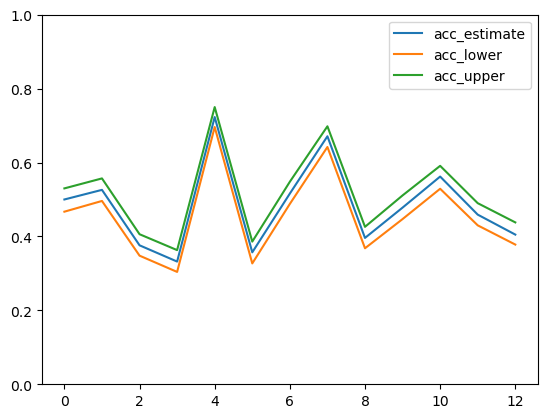

In [78]:
ccs_eval.loc[ccs_eval['ensembling'] == 'full', ['acc_estimate', 'acc_lower', 'acc_upper']].reset_index(drop=True).plot(ylim=(0, 1))

<Axes: >

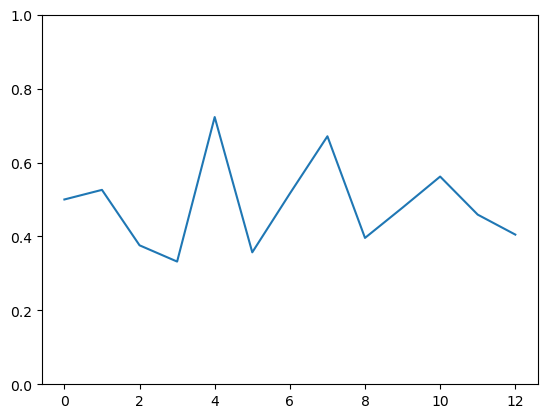

In [79]:
ccs_eval.loc[ccs_eval['ensembling'] == 'full', 'acc_estimate'].reset_index(drop=True).plot(ylim=(0, 1))

## Load the model

We use the [TransformerLens](https://github.com/neelnanda-io/TransformerLens) library to interact with model internals.

The reference documentation can be found [here](https://neelnanda-io.github.io/TransformerLens/transformer_lens.html).

The [main tutorial](https://neelnanda.io/transformer-lens-demo) was very helpful in getting started with the library.

In [10]:
from elk.run import Extract
from elk.extraction import extract, PromptConfig

In [11]:
datasets = extract(Extract(PromptConfig(['ag_news']), 'EleutherAI/pythia-1b'))

Found cached dataset generator (/home/ec2-user/.cache/huggingface/datasets/generator/default-0941e1b920cda0d3/0.0.0)
Found cached dataset generator (/home/ec2-user/.cache/huggingface/datasets/generator/default-db8ee87f26ad1132/0.0.0)


Using 4 of 4 GPUs: [0, 1, 2, 3]
ag_news: using 'train' for training and 'test' for validation


In [12]:
data = datasets.dataset['train'][:4]

In [18]:
len(reporters)

17

In [13]:
data.keys()

dict_keys(['hidden_0', 'hidden_1', 'hidden_2', 'hidden_3', 'hidden_4', 'hidden_5', 'hidden_6', 'hidden_7', 'hidden_8', 'hidden_9', 'hidden_10', 'hidden_11', 'hidden_12', 'hidden_13', 'hidden_14', 'hidden_15', 'hidden_16', 'variant_ids', 'label', 'text_questions', 'model_logits'])

In [14]:
q = data['text_questions'][0]

In [16]:
variants = data['variant_ids'][0]

In [17]:
variants

['classify_question_first',
 'classify_with_choices_question_first',
 'recommend',
 'which_section_choices',
 'which_section',
 'burns_1',
 'burns_2',
 'burns_3',
 'burns_4',
 'burns_5',
 'burns_6',
 'burns_7',
 'burns_8',
 'classify_with_choices',
 'classify']

In [15]:
q

[['What label best describes this news article?\nBangladesh paralysed by strikes Opposition activists have brought many towns and cities in Bangladesh to a halt, the day after 18 people died in explosions at a political rally.',
  'What label best describes this news article?\nBangladesh paralysed by strikes Opposition activists have brought many towns and cities in Bangladesh to a halt, the day after 18 people died in explosions at a political rally.',
  'What label best describes this news article?\nBangladesh paralysed by strikes Opposition activists have brought many towns and cities in Bangladesh to a halt, the day after 18 people died in explosions at a political rally.',
  'What label best describes this news article?\nBangladesh paralysed by strikes Opposition activists have brought many towns and cities in Bangladesh to a halt, the day after 18 people died in explosions at a political rally.'],
 ['Is this a piece of news regarding world politics, sports, business, or science a

In [ ]:
data['label']

In [ ]:
data['label']

In [ ]:
# has shape (batch, n_variants, n_choices)
questions = data['text_questions']

In [ ]:
len(questions)

In [ ]:
len(questions[0])

In [ ]:
questions

In [ ]:
data

In [ ]:
from elk.training.train import Elicit

In [ ]:
from transformer_lens import HookedTransformer

model = HookedTransformer.from_pretrained("EleutherAI/pythia-1b").cuda()

In [ ]:
len(reporters)

In [ ]:
n_layers

In [ ]:
n_layers = model.cfg.n_layers
n_layers, len(reporters) == n_layers

## Load prompts

In the original DLK paper, the authors found that out of the models they tested,
the single decoder-only model (GPT-J-6B) performed the worst (measured in terms of accuracy across datasets).

Later on, researchers at EleutherAI found that this could be resolved by prompting the model using different prompt templates.
Their method leverages that the truth of the given statement should be the same regardless of the prompt template chosen.

In [ ]:
from elk.extraction.prompt_loading import load_prompts
import itertools
import pandas as pd

n_prompts = 12
batch_range = torch.arange(n_prompts)

prompt_datasets = dict()
for dataset in datasets:
    prompt_dataset = load_prompts(dataset, split_type="val")
    prompt_dataset = list(itertools.islice(prompt_dataset, n_prompts))
    prompt_datasets[dataset] = prompt_dataset
    del prompt_dataset

The loaded prompts (each element of the `prompt_dataset` have the following structure:

```
{
    "label": 0 if correct answer is "negative", 1 if correct answer is "positive"
    "prompts": [
        [
            {
                "answer": "negative" or "bad" or ...
                "text": formatted prompt with the "negative" answer
            },
            {
                "answer": "positive" or "good" or ...
                "text": formatted prompt with the "positive" answer
            }
        ],
        ...
    ],
    "template_names": [
        template name for prompt 0,
        ...
    ]
}
```

Note that prompts vary along two binary axes:

1. Whether the statement ends in the "positive" answer or the "negative" answer;
2. Whether the statement is factually correct or incorrect.

It's important to distinguish these two axes; The goal of CCS is to uncover the latter.

In [ ]:
df = pd.DataFrame(prompt_datasets['ag_news'])
df = df.explode(['prompts'])
df = df.explode(['prompts', 'template_names'])
df = df['prompts'].apply(pd.Series).merge(df, left_index=True, right_index=True).drop(["prompts"], axis=1)
df.head()

In [ ]:
dfs = dict()

for dataset, prompt_dataset in prompt_datasets.items():
    records = []

    for j, prompts in enumerate(prompt_dataset):
        for i, ((negative, positive), template_name) in enumerate(
            zip(prompts["prompts"], prompts["template_names"])
        ):
            records.append(
                dict(
                    negative_prompt=negative["text"],
                    positive_prompt=positive["text"],
                    negative_answer=negative["answer"],
                    positive_answer=positive["answer"],
                    label=prompts["label"],
                    incorrect_answer=negative["answer"]
                    if prompts["label"]
                    else positive["answer"],
                    correct_answer=positive["answer"]
                    if prompts["label"]
                    else negative["answer"],
                    template_name=template_name,
                    template_id=i,
                    prompt_id=j,
                )
            )

    # set a multi-index using the prompt_id and template_id
    dfs[dataset] = pd.DataFrame(records).set_index(["prompt_id", "template_id"])
    del dataset, records, prompt_dataset, prompts, negative, positive, template_name

In [ ]:
dfs["super_glue boolq"].head()

In [ ]:
dfs["imdb"].head()

In [ ]:
print(dfs["super_glue boolq"].at[(0, 0), "negative_prompt"])

## Forward pass on the text

In [ ]:
from jaxtyping import Float
from tqdm import tqdm
from transformer_lens.hook_points import HookPoint
import transformer_lens.utils as utils
from functools import partial

Here we fix a given template ID. This gives us a single fully-formatted prompt for each original text sample.

### Preprocessing prompts

In [ ]:
template_id = 2

save_paths = {
    dataset: Path(f"results/ccs/pythia-1b/{dataset}/template-{template_id}")
    for dataset in datasets
}

prompts = {
    dataset: dfs[dataset].loc[pd.IndexSlice[:, template_id], :].reset_index(drop=True)
    for dataset in datasets
}

In [ ]:
prompts["super_glue boolq"].head()

In [ ]:
get_value = lambda column: {
    dataset: prompts[dataset][column].tolist() for dataset in datasets
}
neg_prompts = get_value("negative_prompt")
pos_prompts = get_value("positive_prompt")
correct_answers = get_value("correct_answer")
incorrect_answers = get_value("incorrect_answer")

In [ ]:
neg_tokens = {dataset: model.to_tokens(neg_prompts[dataset]) for dataset in datasets}
pos_tokens = {dataset: model.to_tokens(pos_prompts[dataset]) for dataset in datasets}

neg_str_tokens = {
    dataset: model.to_str_tokens(neg_prompts[dataset]) for dataset in datasets
}
pos_str_tokens = {
    dataset: model.to_str_tokens(pos_prompts[dataset]) for dataset in datasets
}

prompt_lengths = {
    dataset: torch.tensor([len(tokens) for tokens in neg_str_tokens[dataset]])
    for dataset in datasets
}

### Hooks for collecting activation values

In [ ]:
prompt_lengths["super_glue boolq"]

In [ ]:
# the negative and positive prompts match up until the very last token,
# so we just record one and then get only the last token of the other one
neg_results = {
    dataset: torch.zeros(
        (
            n_prompts,
            n_layers,
            prompt_lengths[dataset].max().item(),
        ),
        device="cpu",
    )
    for dataset in datasets
}
pos_results = {
    dataset: torch.zeros((n_prompts, n_layers), device="cpu") for dataset in datasets
}


def projection(
    resid_pre: Float[torch.Tensor, "batch pos d_model"],  # at a given layer
    hook: HookPoint,
    dataset: str,
    layer: int,
):
    # TODO should we be normalizing here?
    # since the prompts have different lengths, technically this is more computation than we need to do
    neg_results[dataset][:, layer, : resid_pre.shape[1]] = reporters[layer](
        resid_pre
    ).cpu()
    return resid_pre


def final_projection(
    resid_pre: Float[torch.Tensor, "batch pos d_model"],  # at a given layer
    hook: HookPoint,
    dataset: str,
    layer: int,
):
    # TODO should we be normalizing here?
    x = resid_pre[batch_range, prompt_lengths[dataset] - 1, :]
    pos_results[dataset][:, layer] = reporters[layer](x).cpu()
    return resid_pre


{dataset: neg_results[dataset].shape for dataset in datasets}

### Extraction loop

In [ ]:
# should be quite fast
for dataset in datasets:
    for layer in tqdm(range(n_layers), desc=dataset):
        act_name = utils.get_act_name("resid_pre", layer)

        patch_hook_fn = partial(projection, dataset=dataset, layer=layer)
        model.run_with_hooks(neg_tokens[dataset], fwd_hooks=[(act_name, patch_hook_fn)])

        patch_hook_fn = partial(final_projection, dataset=dataset, layer=layer)
        model.run_with_hooks(pos_tokens[dataset], fwd_hooks=[(act_name, patch_hook_fn)])

In [ ]:
for dataset in datasets:
    save_path = save_paths[dataset]
    save_path.mkdir(parents=True, exist_ok=True)
    torch.save(neg_results[dataset], save_path / "neg.pt")
    torch.save(pos_results[dataset], save_path / "pos.pt")

## Visualize outputs

In [ ]:
import circuitsvis as cv
from circuitsvis.tokens import colored_tokens

In [ ]:
neg_results = {
    dataset: torch.load(save_paths[dataset] / "neg.pt") for dataset in datasets
}
pos_results = {
    dataset: torch.load(save_paths[dataset] / "pos.pt") for dataset in datasets
}

projections = dict()
for dataset in datasets:
    projections[dataset] = torch.cat(
        [neg_results[dataset], torch.zeros((n_prompts, n_layers, 2))], axis=-1
    )
    projections[dataset][batch_range, :, prompt_lengths[dataset]] = pos_results[dataset]
    projections[dataset][
        batch_range, :, prompt_lengths[dataset] + 1
    ] = 0  # forvisualization

    # make the signs across layers consistent with the final token
    # since CCS only identifies the hyperplane up to sign
    projections[dataset] = (
        pos_results[dataset].sign()[:, :, None] * projections[dataset]
    )

Here we choose a given prompt to visualize. "positive" answers always corresponds to _blue_ and "negative" answers always correspond to _red_
independently of the correct answer.

In [ ]:
def plot_colors(dataset: str, prompt_id: int):
    flattened_tokens = []
    for i in range(n_layers):
        flattened_tokens += (
            neg_str_tokens[dataset][prompt_id]
            + [pos_str_tokens[dataset][prompt_id][-1]]
            + [f"\n\n=====^ layer {i} ^=====\n\n"]
        )
    flattened_projections = projections[dataset][
        prompt_id, :, : prompt_lengths[dataset][prompt_id] + 2
    ].flatten()

    # clip the values to between (-5.5, 4) to make the visualization more readable
    print("distance bounds:", flattened_projections.min(), flattened_projections.max())
    return colored_tokens(
        flattened_tokens, flattened_projections, min_value=-5, max_value=5
    )

In [ ]:
prompt_id = 6

In [ ]:
plot_colors("imdb", prompt_id=prompt_id)

In [ ]:
plot_colors("super_glue boolq", prompt_id=prompt_id)

It's interesting that these almost look like attention patterns! For our experiments on IMDB, the blue tokens are often ones that carry some sort of positive connotation
and the red ones often carry some kind of negative connotation.
The probe for BoolQ seems to favour statistics and proper nouns.
It's also interesting that the logits across the board seem to get farther and farther from the CCS hyperplane
as we go into the later layers of the network.
We're not yet quite sure what's causing this behaviour.
In future experiments we'll try and see if there's any similarities with the actual attention patterns.

## Visualizing attention

In [ ]:
n_plot_tokens = 128
pos_logits, pos_cache = model.run_with_cache(
    pos_tokens["super_glue boolq"][prompt_id][:n_plot_tokens], remove_batch_dim=True
)
pos_cache.to("cpu")
torch.cuda.empty_cache()
cv.attention.attention_patterns(
    tokens=pos_str_tokens["super_glue boolq"][prompt_id][:n_plot_tokens],
    attention=pos_cache["pattern", 8, "attn"],
)